## Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

### Step 1. Import the data from the given .csv file (Google_Stock_Price_Train.csv Download Google_Stock_Price_Train.csv).

In [2]:
df = pd.read_csv('Google_Stock_Price_Train.csv')
timeseries = df[['Open']].values.astype('float32')

### Step 2. Preprocess the data as you see fit

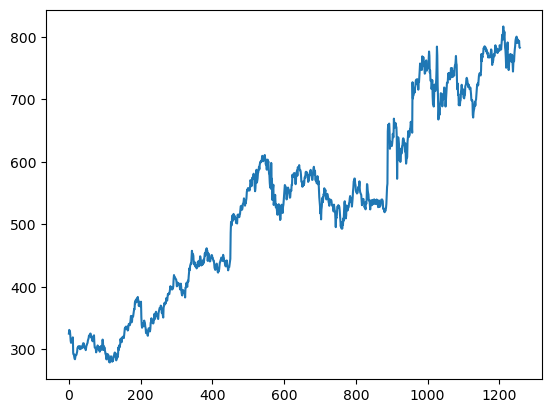

In [3]:
plt.plot(timeseries)
plt.show()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


In [5]:
df.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [6]:
df.shape

(1258, 6)

### Step 3. Split into 80% train 20% prediction

In [7]:
# train-test split for time series
train_size = int(len(timeseries) * 0.8)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [8]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([1002, 4, 1]) torch.Size([1002, 4, 1])
torch.Size([248, 4, 1]) torch.Size([248, 4, 1])


C:\Users\16284\AppData\Local\Temp\ipykernel_4856\3189246061.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  return torch.tensor(X), torch.tensor(y)


In [9]:
class my_LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

### Step 4. Train the model on the data

In [10]:
model = my_LSTM()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 491.3119, test RMSE 739.5325
Epoch 100: train RMSE 204.9726, test RMSE 427.7267
Epoch 200: train RMSE 54.4657, test RMSE 170.6366
Epoch 300: train RMSE 20.0578, test RMSE 73.2018
Epoch 400: train RMSE 11.5732, test RMSE 36.4905
Epoch 500: train RMSE 9.2895, test RMSE 22.6264
Epoch 600: train RMSE 10.9105, test RMSE 22.3376
Epoch 700: train RMSE 9.2369, test RMSE 21.0854
Epoch 800: train RMSE 8.5750, test RMSE 15.1372
Epoch 900: train RMSE 8.5506, test RMSE 14.7592
Epoch 1000: train RMSE 9.7418, test RMSE 14.9949
Epoch 1100: train RMSE 11.1105, test RMSE 19.7470
Epoch 1200: train RMSE 9.2525, test RMSE 17.9161
Epoch 1300: train RMSE 8.2199, test RMSE 14.6371
Epoch 1400: train RMSE 8.5363, test RMSE 14.6526
Epoch 1500: train RMSE 8.7843, test RMSE 14.4799
Epoch 1600: train RMSE 8.3557, test RMSE 14.2017
Epoch 1700: train RMSE 8.2911, test RMSE 15.2978
Epoch 1800: train RMSE 8.3422, test RMSE 14.9839
Epoch 1900: train RMSE 8.9053, test RMSE 16.4485


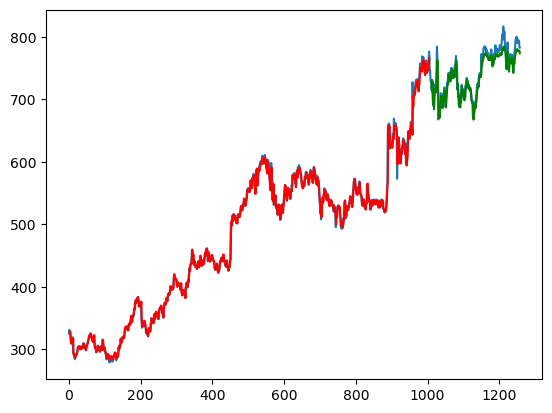

In [11]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]


# plot
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

### Step 5. Report on the results of your model

As seen in the above graph, the model is performing quite well as there is no huge difference between train_plot and test_plot.

We can also see that RMSE is decreasing continuously during training and testing over epochs and there is no huge difference which also tellu us that our model has learnt and performed well.

I also tried applying normalization but there was no huge difference as such and without normalization itself the model is performing well.

## Github: https://github.com/daminivichare66/LSTM-Stock-Predictions